# Training an Object Detection Model

In this notebook, we give an introduction to training an object detection model using [torchvision](https://pytorch.org/docs/stable/torchvision/index.html). Using a small dataset, we demonstrate how to train and evaluate a FasterRCNN object detection model. We also cover one of the most common ways to store data on a file system for this type of problem.

To learn more about how object detection work, visit our [FAQ](../FAQ.md).

## Initialization

In [1]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the .py files in 'p2/code' needed for this problem
# e.g. 'cs231a/representation_learning':
FOLDERNAME = 'cs231a/final'

assert FOLDERNAME is not None, "[!] Enter the foldername."

%cd drive/My\ Drive
%cd $FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive
/content/drive/My Drive/cs231a/final


In [3]:
pip install cytoolz

     |████████████████████████████████| 481 kB 5.3 MB/s 
  Created wheel for cytoolz: filename=cytoolz-0.11.2-cp37-cp37m-linux_x86_64.whl size=1230845 sha256=4c8838002f2d0ec72829ee8af165a00e08a466dbd73595c7301ef834257fc80d
  Stored in directory: /root/.cache/pip/wheels/38/70/71/ca13ea3d36ccd0b3d0ec7d7a4ca67522048d695b556bba4f59
Successfully built cytoolz


In [4]:
import sys

sys.path.append("../../")

import os
import time
import matplotlib.pyplot as plt
from typing import Iterator
from pathlib import Path
from PIL import Image
from random import randrange
from typing import Tuple
import torch
import torchvision
from torchvision import transforms
import scrapbook as sb

from utils_cv.classification.data import Urls as UrlsIC
from utils_cv.common.data import unzip_url, data_path
from utils_cv.detection.data import Urls
from utils_cv.detection.dataset import DetectionDataset, get_transform
from utils_cv.detection.plot import (
    plot_grid,
    plot_boxes,
    plot_pr_curves,
    PlotSettings,
    plot_counts_curves,
    plot_detections
)
from utils_cv.detection.model import (
    DetectionLearner,
    get_pretrained_fasterrcnn,
    get_pretrained_maskrcnn,
    get_pretrained_keypointrcnn
)
from utils_cv.common.gpu import which_processor, is_windows

# Change matplotlib backend so that plots are shown for windows
if is_windows():
    plt.switch_backend("TkAgg")

print(f"TorchVision: {torchvision.__version__}")
which_processor()

TorchVision: 0.11.1+cu111
Torch is using GPU: Tesla K80


In [5]:
# Ensure edits to libraries are loaded and plotting is shown in the notebook.
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [6]:
DATA_PATH = unzip_url(Urls.fridge_objects_path, exist_ok=True)
NEG_DATA_PATH = unzip_url(UrlsIC.fridge_objects_negatives_path, exist_ok=True)
EPOCHS = 10
LEARNING_RATE = 0.005
IM_SIZE = 500
SAVE_MODEL = True

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using torch device: {device}")

Using torch device: cuda


In [7]:
print(DATA_PATH)

/content/drive/My Drive/cs231a/final/data/odFridgeObjects


In [ ]:
ASL_DATA_PATH = '/content/drive/My Drive/cs231a/final/data/asl'
# ASL_NEG_DATA_PATH = unzip_url(UrlsIC.fridge_objects_negatives_path, exist_ok=True)
ASL_EPOCHS = 10
ASL_LEARNING_RATE = 0.005
ASL_IM_SIZE = 500
ASL_SAVE_MODEL = True

# train on the GPU or on the CPU, if a GPU is not available
ASL_device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using torch device: {ASL_device}")

Using torch device: cuda


In [ ]:
print(ASL_DATA_PATH)

/content/drive/My Drive/cs231a/final/data/asl


In [8]:
path = Path(DATA_PATH)
os.listdir(path)

['.DS_Store', 'annotations', 'images']

In [ ]:
ASL_path = Path(ASL_DATA_PATH)
os.listdir(ASL_path)

['annotations', 'images']

In [9]:
data = DetectionDataset(DATA_PATH, train_pct=0.75)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
ASL_data = DetectionDataset(ASL_DATA_PATH, train_pct=0.75)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [10]:
print(
    f"Training dataset: {len(data.train_ds)} | Training DataLoader: {data.train_dl} \
    \nTesting dataset: {len(data.test_ds)} | Testing DataLoader: {data.test_dl}"
)

Training dataset: 96 | Training DataLoader: <torch.utils.data.dataloader.DataLoader object at 0x7f150b66a190>     
Testing dataset: 32 | Testing DataLoader: <torch.utils.data.dataloader.DataLoader object at 0x7f150b65c050>


In [ ]:
print(
    f"Training dataset: {len(ASL_data.train_ds)} | Training DataLoader: {ASL_data.train_dl} \
    \nTesting dataset: {len(ASL_data.test_ds)} | Testing DataLoader: {ASL_data.test_dl}"
)

Training dataset: 1134 | Training DataLoader: <torch.utils.data.dataloader.DataLoader object at 0x7f4b8e0d1410>     
Testing dataset: 377 | Testing DataLoader: <torch.utils.data.dataloader.DataLoader object at 0x7f4bac679b10>


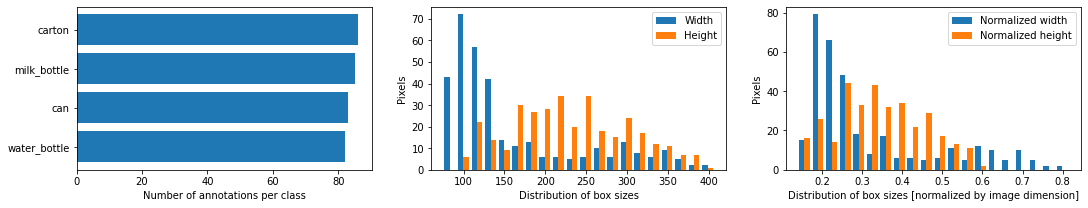

In [11]:
data.plot_boxes_stats()

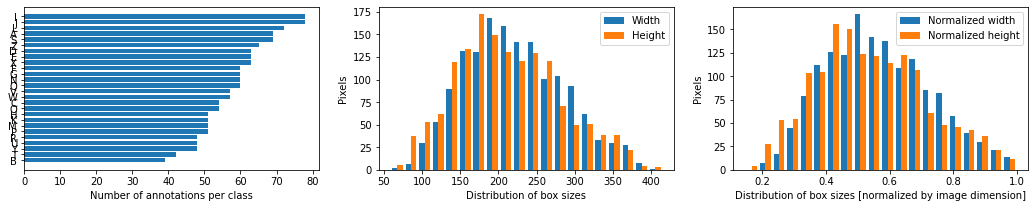

In [ ]:
ASL_data.plot_boxes_stats()

Transformations applied on /content/drive/My Drive/cs231a/final/data/odFridgeObjects/images/83.jpg:


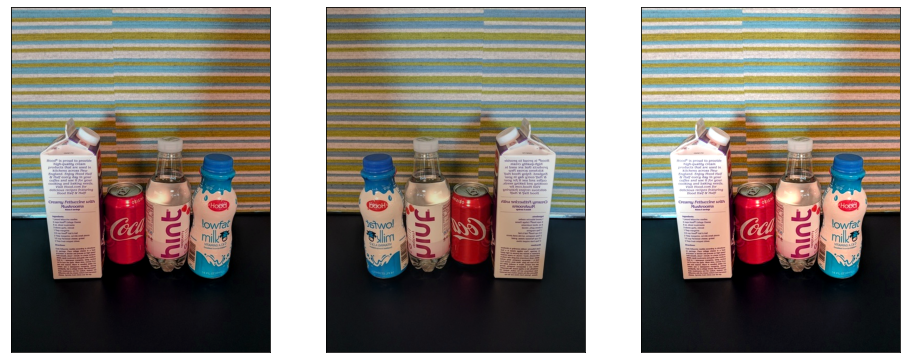

In [12]:
data.train_ds.dataset.show_im_transformations()

Transformations applied on /content/drive/My Drive/cs231a/final/data/asl/images/V17_jpg.rf.18801d8e6ad486e7e038a1565ebf1736.jpg:


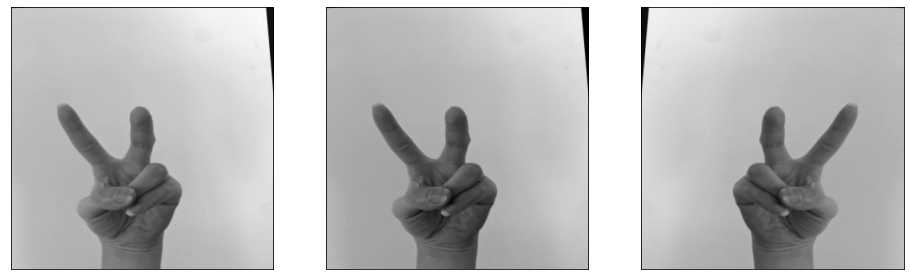

In [ ]:
ASL_data.train_ds.dataset.show_im_transformations()

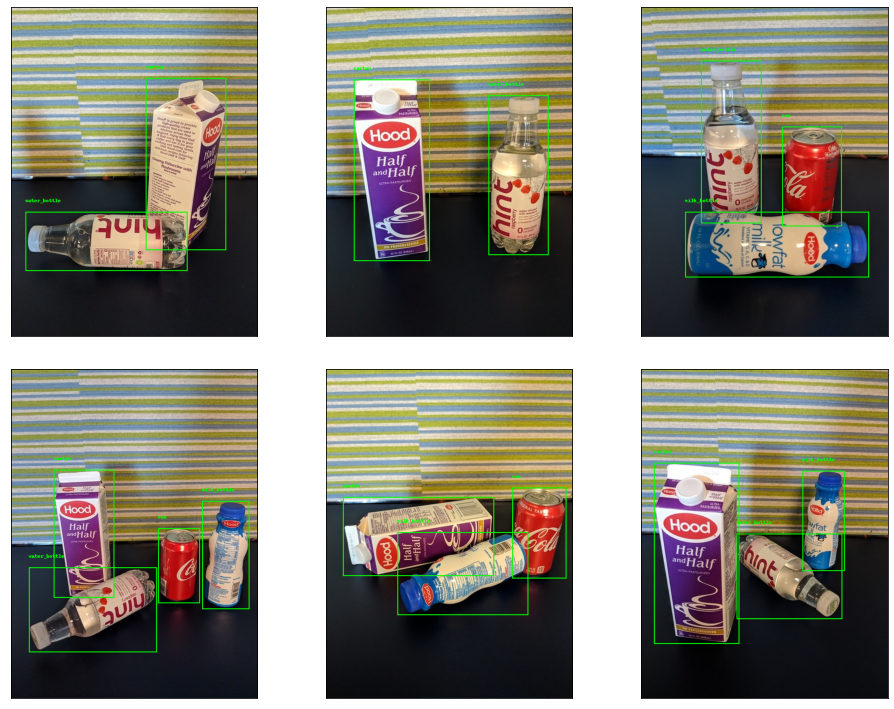

In [13]:
data.show_ims(rows=2)

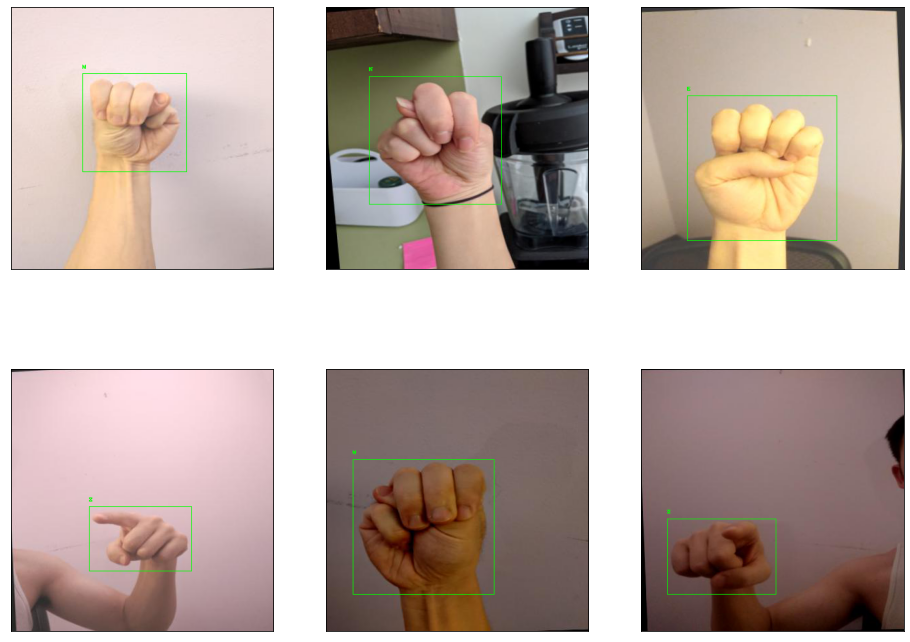

In [ ]:
ASL_data.show_ims(rows=2)

# Finetune a Pretrained Model

For the DetectionLearner, we use Faster R-CNN as the default model, and Stochastic Gradient Descent as our default optimizer. 

Our Faster R-CNN model is pretrained on COCO, a large-scale object detection, segmentation, and captioning dataset that contains over 200K labeled images with over 80 label cateogories.

When we initialize the DetectionLearner, we can pass in the dataset. By default, the object will set the model to torchvision's Faster R-CNN. Alternatively, we can pass in the model we want to use - we would customize the model using the `get_pretrained_fasterrcnn` function and specify the parameters we want. 

In [14]:
detector = DetectionLearner(data, im_size=IM_SIZE)
print(f"Model: {type(detector.model)}")

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

Model: <class 'torchvision.models.detection.faster_rcnn.FasterRCNN'>


In [ ]:
ASL_detector = DetectionLearner(ASL_data, im_size=IM_SIZE)
print(f"Model: {type(ASL_detector.model)}")

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

Model: <class 'torchvision.models.detection.faster_rcnn.FasterRCNN'>


In [ ]:
# mask_detector = DetectionLearner(data, model=get_pretrained_maskrcnn(len(data.labels) + 1,min_size=500,max_size=500))
# print(f"Model: {type(mask_detector.model)}")

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

Model: <class 'torchvision.models.detection.mask_rcnn.MaskRCNN'>


In [ ]:
# keypoint_detector = DetectionLearner(data, model=get_pretrained_keypointrcnn(len(data.labels) + 1,min_size=500,max_size=500))
# print(f"Model: {type(keypoint_detector.model)}")

Downloading: "https://download.pytorch.org/models/keypointrcnn_resnet50_fpn_coco-fc266e95.pth" to /root/.cache/torch/hub/checkpoints/keypointrcnn_resnet50_fpn_coco-fc266e95.pth


  0%|          | 0.00/226M [00:00<?, ?B/s]

Model: <class 'torchvision.models.detection.keypoint_rcnn.KeypointRCNN'>


In [15]:
skip_evaluation = device.type == 'cpu'

In [18]:
detector.fit(10, lr=0.001, print_freq=30, skip_evaluation=skip_evaluation)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: [0]  [ 0/48]  eta: 0:02:45  lr: 0.000022  loss: 0.0114 (0.0114)  loss_classifier: 0.0042 (0.0042)  loss_box_reg: 0.0070 (0.0070)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0002 (0.0002)  time: 3.4554  data: 1.9799  max mem: 937
Epoch: [0]  [30/48]  eta: 0:00:12  lr: 0.000660  loss: 0.0298 (0.0330)  loss_classifier: 0.0131 (0.0130)  loss_box_reg: 0.0163 (0.0195)  loss_objectness: 0.0001 (0.0002)  loss_rpn_box_reg: 0.0002 (0.0003)  time: 0.5974  data: 0.0002  max mem: 937
Epoch: [0]  [47/48]  eta: 0:00:00  lr: 0.001000  loss: 0.0290 (0.0315)  loss_classifier: 0.0121 (0.0128)  loss_box_reg: 0.0165 (0.0182)  loss_objectness: 0.0001 (0.0002)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.5971  data: 0.0002  max mem: 937
Epoch: [0] Total time: 0:00:31 (0.6662 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:22  model_time: 0.3059 (0.3059)  evaluator_time: 0.0038 (0.0038)  time: 1.4131  data: 1.1005  max mem: 937
Test:  [15/16]  eta: 0:00:00  model_time: 0.30

In [ ]:
ASL_detector.fit(EPOCHS, lr=LEARNING_RATE, print_freq=30, skip_evaluation=skip_evaluation)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: [0]  [  0/567]  eta: 0:24:15  lr: 0.000014  loss: 3.8933 (3.8933)  loss_classifier: 3.7714 (3.7714)  loss_box_reg: 0.0646 (0.0646)  loss_objectness: 0.0541 (0.0541)  loss_rpn_box_reg: 0.0032 (0.0032)  time: 2.5666  data: 1.1086  max mem: 1202
Epoch: [0]  [ 30/567]  eta: 0:05:13  lr: 0.000279  loss: 0.5253 (1.8785)  loss_classifier: 0.3534 (1.7165)  loss_box_reg: 0.1254 (0.1395)  loss_objectness: 0.0132 (0.0184)  loss_rpn_box_reg: 0.0023 (0.0040)  time: 0.5140  data: 0.0002  max mem: 1468
Epoch: [0]  [ 60/567]  eta: 0:04:40  lr: 0.000543  loss: 0.3695 (1.1486)  loss_classifier: 0.2009 (0.9855)  loss_box_reg: 0.1569 (0.1456)  loss_objectness: 0.0077 (0.0142)  loss_rpn_box_reg: 0.0019 (0.0033)  time: 0.5202  data: 0.0002  max mem: 1468
Epoch: [0]  [ 90/567]  eta: 0:04:18  lr: 0.000808  loss: 0.3455 (0.8874)  loss_classifier: 0.1792 (0.7216)  loss_box_reg: 0.1635 (0.1511)  loss_objectness: 0.0009 (0.0118)  loss_rpn_box_reg: 0.0020 (0.0030)  time: 0.5215  data: 0.0003  max mem: 1468


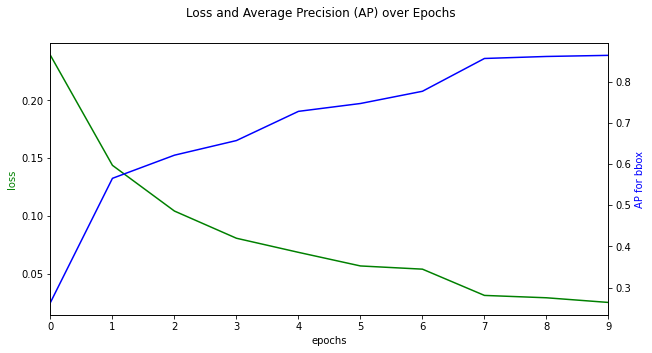

In [ ]:
if not skip_evaluation:
    ASL_detector.plot_precision_loss_curves()

In [ ]:
if not skip_evaluation:
    e = ASL_detector.evaluate()

creating index...
index created!


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Test:  [  0/189]  eta: 0:05:02  model_time: 0.4100 (0.4100)  evaluator_time: 0.0065 (0.0065)  time: 1.5994  data: 1.1803  max mem: 1468
Test:  [100/189]  eta: 0:00:24  model_time: 0.2526 (0.2552)  evaluator_time: 0.0031 (0.0034)  time: 0.2587  data: 0.0002  max mem: 1468
Test:  [188/189]  eta: 0:00:00  model_time: 0.2569 (0.2559)  evaluator_time: 0.0033 (0.0035)  time: 0.2574  data: 0.0002  max mem: 1468
Test: Total time: 0:00:50 (0.2692 s / it)
Averaged stats: model_time: 0.2569 (0.2559)  evaluator_time: 0.0033 (0.0035)
Accumulating evaluation results...
DONE (t=0.24s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.863
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.998
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.991
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.617
 Ave

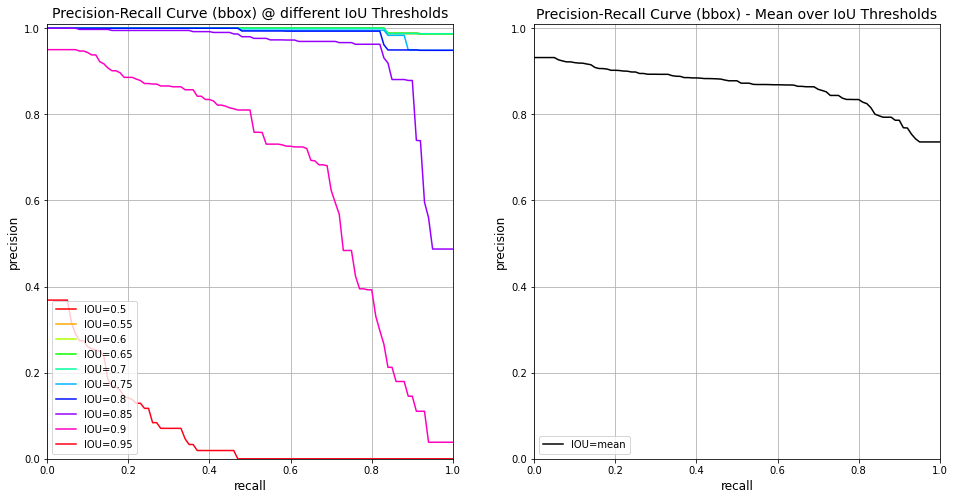

In [ ]:
if not skip_evaluation:
    plot_pr_curves(e)

Running detector on 32 test images...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Running detector on 64 negative images...


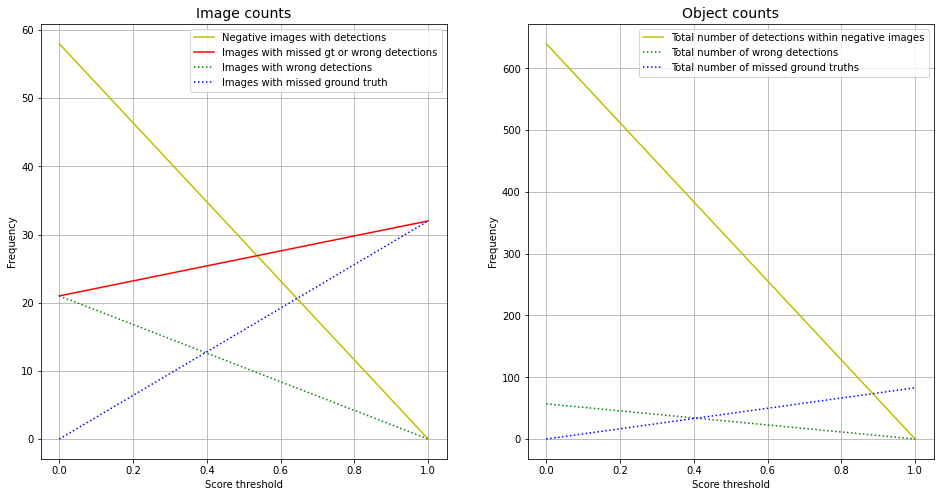

In [ ]:
# Run detector on the test images. Set threshold to 0 to keep all low confidence detections.
print(f"Running detector on {len(data.test_ds)} test images...")
detections = detector.predict_dl(data.test_dl, threshold=0)

# Run detector on the negative images
if NEG_DATA_PATH is None or NEG_DATA_PATH == "":
    detections_neg = None
else:
    neg_data = DetectionDataset(
        NEG_DATA_PATH,
        train_pct=1.0,  # , batch_size=BATCH_SIZE,
        im_dir="",
        allow_negatives=True,
        train_transforms=get_transform(train=False),
    )
    print(f"Running detector on {len(neg_data.train_ds)} negative images...")
    detections_neg = detector.predict_dl(neg_data.train_dl, threshold=0)

# Count and plot number of wrong/missing detections
plot_counts_curves(detections, data.test_ds, detections_neg)

In [ ]:
print(f"Running detector on {len(ASL_data.test_ds)} test images...")
detections = ASL_detector.predict_dl(ASL_data.test_dl, threshold=0)

Running detector on 377 test images...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
detections[:5]

[{'det_bboxes': [{Bbox object: [left=85, top=57, right=262, bottom=323] | <B> | label:7 | path:/content/drive/My Drive/cs231a/final/data/asl/images/B8_jpg.rf.c35c7270b4beba7e31bbb9dae22d5c82.jpg} | score: 0.982193112373352],
  'idx': 107,
  'im_path': '/content/drive/My Drive/cs231a/final/data/asl/images/B8_jpg.rf.c35c7270b4beba7e31bbb9dae22d5c82.jpg'},
 {'det_bboxes': [{Bbox object: [left=163, top=128, right=299, bottom=259] | <Q> | label:20 | path:/content/drive/My Drive/cs231a/final/data/asl/images/Q11_jpg.rf.47af03900b486f8e43485cae66983972.jpg} | score: 0.9924522042274475],
  'idx': 957,
  'im_path': '/content/drive/My Drive/cs231a/final/data/asl/images/Q11_jpg.rf.47af03900b486f8e43485cae66983972.jpg'},
 {'det_bboxes': [{Bbox object: [left=159, top=138, right=370, bottom=376] | <X> | label:9 | path:/content/drive/My Drive/cs231a/final/data/asl/images/X4_jpg.rf.e2f2c6b235e95f166ea949b04f801d00.jpg} | score: 0.9811331629753113],
  'idx': 1385,
  'im_path': '/content/drive/My Drive/c

In [ ]:
print(
    f"Number of detections: {len(detections)}\nNumber of test images: {len(ASL_data.test_ds)}"
)

Number of detections: 377
Number of test images: 377


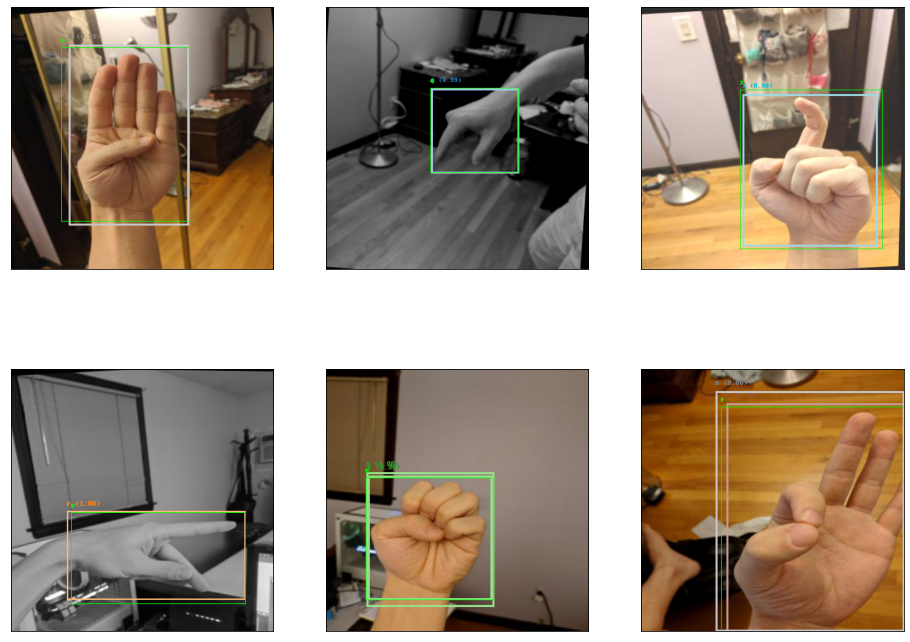

In [ ]:
def _grid_helper():
    for detection in detections:
        yield detection, ASL_data, None, None
plot_grid(plot_detections, _grid_helper(), rows=2)

In [ ]:
ASL_new_im_path = ASL_data.root / ASL_data.im_dir / ASL_data.im_paths[randrange(len(ASL_data))]
ASL_new_im_path

PosixPath('/content/drive/My Drive/cs231a/final/data/asl/images/Y15_jpg.rf.aca2466b3c911a5e1c8a4064d0047c4e.jpg')

In [ ]:
detections = ASL_detector.predict(ASL_new_im_path, threshold=0.5)

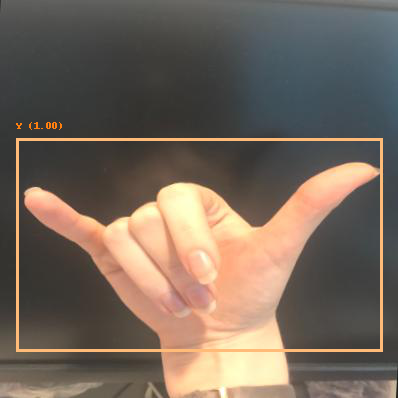

In [ ]:
plot_detections(detections)